In [6]:
import json
from shapely.geometry import shape
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

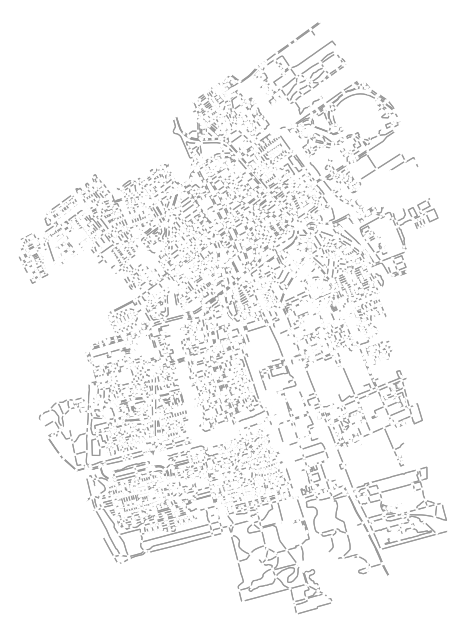

In [2]:
import osmnx as ox
import matplotlib.pyplot as plt

# Define a smaller bounding box (north, south, east, west) for a specific area in Delft
north = 52.0125  # Northernmost latitude (adjust as needed)
south = 52.0110  # Southernmost latitude (adjust as needed)
east = 4.3610    # Easternmost longitude (adjust as needed)
west = 4.3540    # Westernmost longitude (adjust as needed)

# Download the pedestrian network within the smaller bounding box
# G = ox.graph_from_bbox((north, south, east, west), network_type='walk')
place_name = "Delft, Netherlands"
G = ox.graph_from_place(place_name, network_type='walk')
# Plot the pedestrian network
fig, ax = ox.plot_graph(G, node_size=5, edge_linewidth=0.8, bgcolor="white")
plt.show()

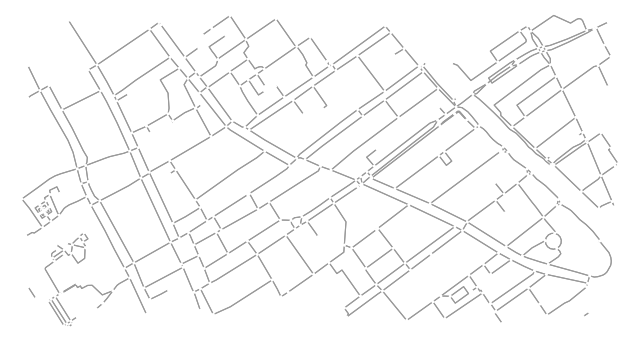

In [5]:
import osmnx as ox

# Step 1: Download the full pedestrian network for Delft
place_name = "Delft, Netherlands"
G_full = ox.graph_from_place(place_name, network_type='walk')

# Step 2: Define the bounding box for the smaller area (example coordinates)
north, west, south, east =  52.015138004863104, 4.3534506404986075, 52.0102238436082, 4.368840442155412  # Adjust these values as needed

# Step 3: Filter the network based on the bounding box
# Get nodes within the bounding box
nodes = ox.graph_to_gdfs(G_full, nodes=True, edges=False)
filtered_nodes = nodes[(nodes['y'] <= north) & (nodes['y'] >= south) &
                        (nodes['x'] <= east) & (nodes['x'] >= west)]

# Get the edges that connect the filtered nodes
edges = ox.graph_to_gdfs(G_full, nodes=False, edges=True)
# add u and v nodes to the keys
# Extract the 'u' (source) and 'v' (target) columns from the MultiIndex
edges['u'] = edges.index.get_level_values(0)  # First level of the index
edges['v'] = edges.index.get_level_values(1)  # Second level of the index
filtered_edges = edges[edges['u'].isin(filtered_nodes.index) & edges['v'].isin(filtered_nodes.index)]


# Create a new graph from the filtered nodes and edges
G_filtered = ox.graph_from_gdfs(filtered_nodes, filtered_edges)

# Step 4: Plot the filtered pedestrian network
fig, ax = ox.plot_graph(G_filtered, node_size=5, edge_linewidth=0.8, bgcolor="white")
# plt.title("Filtered Pedestrian Network in Delft")
# plt.show()

In [6]:
import networkx as nx
import numpy as np
adj_matrix = nx.adjacency_matrix(G_filtered).todense()
is_symmetric = np.allclose(adj_matrix, adj_matrix.T)
print(f"Is adjacency matrix symmetric? {is_symmetric}")

Is adjacency matrix symmetric? True


In [9]:
from scipy.sparse import csr_matrix
import networkx as nx
# Convert graph to a GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G_filtered)
G_simplified = G_filtered.copy()
# print(f"Number of disconnected nodes removed: {len(nodes_to_remove)}")
adj_matrix = nx.adjacency_matrix(G_filtered).todense()
is_symmetric = np.allclose(adj_matrix, adj_matrix.T)
print(f"Is adjacency matrix symmetric? {is_symmetric}")

Is adjacency matrix symmetric? True


In [10]:
# remove the edges that with a distance less than 10 meters
import osmnx as ox
import folium
from shapely.geometry import Point
import numpy as np
from shapely.geometry import Point, LineString

nodes_to_remove = set()
def calculate_distance(point1, point2):
    return point1.distance(point2) * 111000  # Convert degrees to 
# Set threshold (adjust this value based on your needs)
distance_threshold = 10  # meters

# Iterate through nodes
for idx1, row1 in nodes.iterrows():
    if idx1 in nodes_to_remove:
        continue
    
    for idx2, row2 in nodes.iterrows():
        if idx1 != idx2 and idx2 not in nodes_to_remove:
            distance = calculate_distance(row1.geometry, row2.geometry)
            if distance < distance_threshold:
                # Before removing node2, get its neighbors
                neighbors = list(G_simplified.neighbors(idx2))
                # Add edges between node1 and all neighbors of node2
                for neighbor in neighbors:
                    # if neighbor != idx1:
                    #     if not G_simplified.has_edge(idx1, neighbor):
                    #     # Create geometry for the new edge
                    #         line = LineString([row1.geometry, nodes.loc[neighbor].geometry])
                    #         # Add new edge with same attributes as existing edges
                    #         G_simplified.add_edge(idx1, neighbor, geometry=line)
                    #         G_simplified.add_edge(neighbor, idx1, geometry=line)
                    if neighbor != idx1 and not G_simplified.has_edge(idx1, neighbor):
                        # 1. Get attributes from the original edge to preserve them
                        attrs = G_simplified.get_edge_data(idx2, neighbor, 0).copy()

                        # 2. Create new geometry and calculate new length
                        line = LineString([row1.geometry, filtered_nodes.loc[neighbor].geometry])
                        new_length = calculate_distance(row1.geometry, filtered_nodes.loc[neighbor].geometry)

                        # 3. Update attributes for the new edge
                        attrs['geometry'] = line
                        attrs['length'] = new_length
                        # 4. Add the new edge with all attributes
                        G_simplified.add_edge(idx1, neighbor, **attrs)

                        # 5. Do the same for the reverse edge if it exists
                        if G_simplified.has_edge(neighbor, idx2):
                            rev_attrs = G_simplified.get_edge_data(neighbor, idx2, 0).copy()
                            rev_attrs['geometry'] = line
                            rev_attrs['length'] = new_length
                            G_simplified.add_edge(neighbor, idx1, **rev_attrs)
                nodes_to_remove.add(idx2)

# Remove the identified nodes
G_simplified.remove_nodes_from(nodes_to_remove)
# remove the nodes that have no edges
G_simplified.remove_nodes_from(list(nx.isolates(G_simplified)))
largest_cc = max(nx.strongly_connected_components(G_simplified), key=len)
nodes_to_remove = nodes_to_remove.union(set(G_simplified.nodes()) - set(largest_cc))
G_simplified.remove_nodes_from(nodes_to_remove)
print(f"Original number of nodes: {len(G_filtered.nodes)}")
print(f"Number of nodes removed: {len(nodes_to_remove)}")
print(f"Remaining nodes: {len(G_simplified.nodes)}")


Original number of nodes: 365
Number of nodes removed: 63
Remaining nodes: 298


In [ ]:
# rename the nodes
# Create a mapping of old node IDs to new sequential IDs
mapping = {old_id: new_id for new_id, old_id in enumerate(G_simplified.nodes())}

# Relabel the nodes
G_renamed = nx.relabel_nodes(G_simplified, mapping)

# Extract node positions with new IDs
pos = {}
for node in G_renamed.nodes():
    # Get the original node ID using the reverse mapping
    original_node = list(mapping.keys())[list(mapping.values()).index(node)]
    pos[node] = (G_simplified.nodes[original_node]['x'], G_simplified.nodes[original_node]['y'])

# # Create a new figure
# plt.figure(figsize=(12, 8))

# # Draw the network
# nx.draw_networkx_nodes(G_renamed, pos, node_size=5, node_color='skyblue')
# nx.draw_networkx_edges(G_renamed, pos, width=1, alpha=0.5)
# nx.draw_networkx_labels(G_renamed, pos, font_size=1)

# plt.title("Delft Pedestrian Network (Renamed Nodes)")
# plt.axis('on')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# Print some statistics
print(f"Number of nodes: {G_renamed.number_of_nodes()}")
print(f"Number of edges: {G_renamed.number_of_edges()}")

# Get the adjacency matrix of renamed graph
adj_matrix_renamed = nx.adjacency_matrix(G_renamed).todense()

# Save the mapping if needed for future reference
# mapping_df = pd.DataFrame.from_dict(mapping, orient='index', columns=['new_id'])
print("\nFirst few entries of the node mapping:")
# print(mapping_df.head())

NameError: name 'G_simplified' is not defined

In [9]:
# calculate the area of the nodes
# Assuming pos is your dictionary of node positions {node_id: (x, y)}
lats = [pos[1] for pos in pos.values()]
lons = [pos[0] for pos in pos.values()]

# Calculate the bounding box
min_lat, max_lat = min(lats), max(lats)
min_lon, max_lon = min(lons), max(lons)

# Calculate dimensions in degrees
lat_range = max_lat - min_lat
lon_range = max_lon - min_lon

# Convert to approximate kilometers (rough approximation)
# 1 degree latitude ≈ 111 km
# 1 degree longitude ≈ 111 km * cos(latitude)
avg_lat = (max_lat + min_lat) / 2  # use average latitude for longitude conversion
area_km2 = lat_range * 111 * lon_range * 111 * np.cos(np.radians(avg_lat))

print(f"Bounding box dimensions:")
print(f"Latitude range: {lat_range:.6f}° ({lat_range * 111:.2f} km)")
print(f"Longitude range: {lon_range:.6f}° ({lon_range * 111 * np.cos(np.radians(avg_lat)):.2f} km)")
print(f"Approximate area: {area_km2:.2f} km²")


Bounding box dimensions:
Latitude range: 0.004891° (0.54 km)
Longitude range: 0.015151° (1.04 km)
Approximate area: 0.56 km²


In [7]:
import osmnx as ox
import folium
# Convert graph to a GeoDataFrame
# nodes, edges = ox.graph_to_gdfs(G_simplified)
nodes, edges = ox.graph_to_gdfs(G_renamed)
# Create a folium map
m = folium.Map(location=[52.00667, 4.35556], zoom_start=12)  # Melbourne's coordinates

# Add edges to the map
for _, row in edges.iterrows():
    coords = [(y, x) for x, y in row["geometry"].coords]
    folium.PolyLine(coords, color="blue", weight=2).add_to(m)

# Add nodes to the map
for idx, row in nodes.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="red",
        fill=True,
        fillOpacity=0.7
    ).add_to(m)

# Display the map
m

In [15]:
# get the adjacency matrix and position of nodes of the simpilified graph
adjacency_matrix = nx.adjacency_matrix(G_renamed).todense()
# extract the edge distance
edge_distances = nx.get_edge_attributes(G_renamed, 'length')
edge_widths = nx.get_edge_attributes(G_renamed, 'width')

In [16]:
# Clean up edge distances dictionary
processed_edge_distances = {(start, end): dist for (start, end, _), dist in edge_distances.items()}

# Using Pickle
import pickle

# Save
with open("data/delft/edge_distances.pkl", 'wb') as f:  # Note: 'wb' for binary write
    pickle.dump(processed_edge_distances, f)

In [17]:
len(processed_edge_distances)

819

In [63]:
# Check if matrix is symmetric
is_symmetric = np.allclose(adjacency_matrix, adjacency_matrix.T, atol=1e-8)
print(f"Is adjacency matrix symmetric? {is_symmetric}")

Is adjacency matrix symmetric? True


# Save Adj and Positions

In [84]:
# JSON approach
import json

# Saving
with open("data/delft/node_positions.json", 'w') as f:
    json.dump({str(k): list(v) for k, v in pos.items()}, f)

# Loading
with open("data/delft/node_positions.json", 'r') as f:
    pos = {int(k): tuple(v) for k, v in json.load(f).items()}

import numpy as np
# Convert sparse matrix to dense numpy array and ensure float type
adj_matrix = nx.adjacency_matrix(G_simplified)  # Get sparse matrix
adj_matrix = adj_matrix.todense()  # Convert to dense matrix
adj_matrix = np.array(adj_matrix, dtype=float)  # Convert to numpy array with float type
# check if all elements are not greater than 1, if so, set to 1
adj_matrix[adj_matrix > 1] = 1
# diagnal matrix set to 0
np.fill_diagonal(adj_matrix, 0)


# Save the adjacency matrix
np.save("delft_adj_matrix2.npy", adj_matrix)
# Load it back
adj_matrix_loaded = np.load("delft_adj_matrix2.npy", allow_pickle=False)

# Verify the loading worked correctly
print(f"Matrix shape: {adj_matrix_loaded.shape}")
print(f"Are matrices identical? {np.array_equal(adj_matrix, adj_matrix_loaded)}")

Matrix shape: (298, 298)
Are matrices identical? True


## Load the simulated data and visualize

In [1]:
from handlers.output_handler import OutputHandler
from src.utils.visualizer import NetworkVisualizer
import os
import json
import numpy as np

output_dir = os.path.join(".", "outputs")
# Load and analyze results
# simulation_dir = "/Users/mmai/Devs/Crowd-Control/outputs/sim_20250118_124616"  # Replace with actual timestamp

# data = OutputHandler.load_simulation(simulation_dir)
with open("data/delft/node_positions.json", 'r') as f:
    pos = {str(k): np.array(v) for k, v in json.load(f).items()}



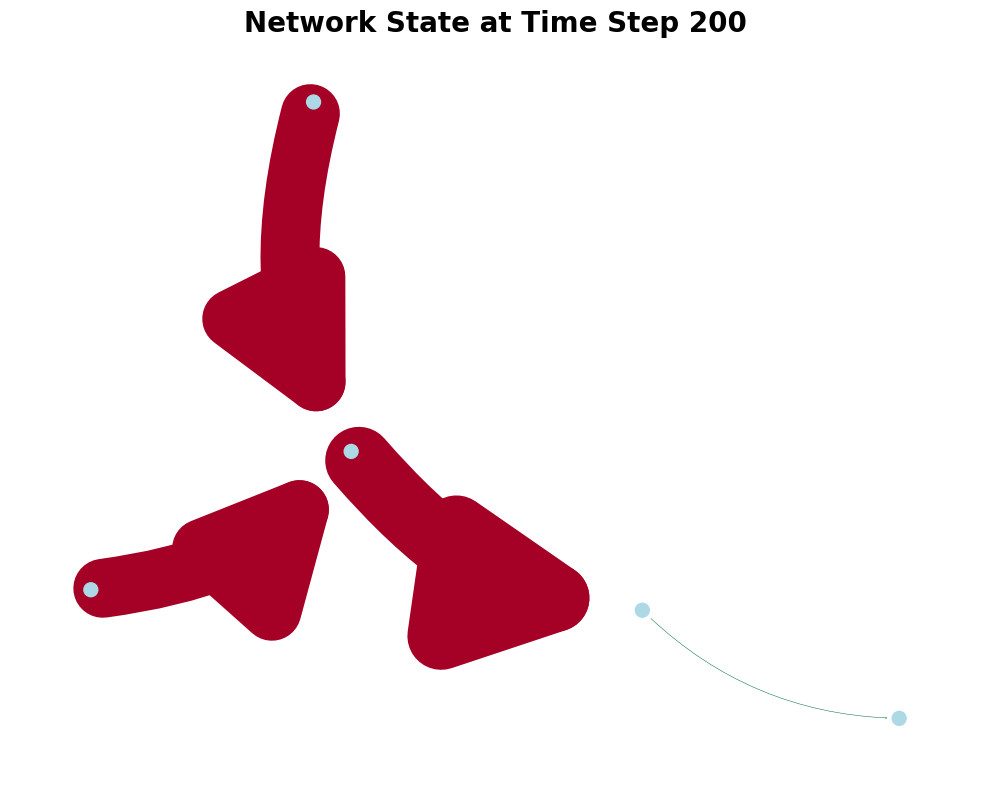

In [13]:
visualizer = NetworkVisualizer(simulation_dir=os.path.join(output_dir, "forky_queues"))
# visualizer = NetworkVisualizer(simulation_dir=os.path.join(output_dir, "delft_directions"), pos=pos)
time_step = 200
fig, ax = visualizer.visualize_network_state(time_step=time_step, edge_property='density', with_colorbar=False)
# visualizer.visualize_network_state(time_step=200, edge_property='num_pedestrians', use_folium=True)

# m = visualizer.visualize_network_state(time_step=270, edge_property='num_pedestrians')
# m.save('network_state_t270.html')
# save the figure
# fig.savefig(f'network_state_t{time_step}.png', bbox_inches='tight', dpi=300, transparent=True)


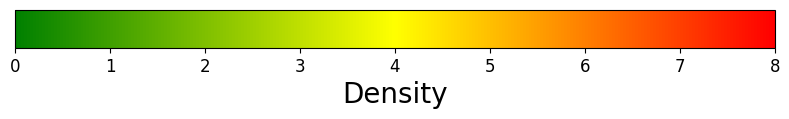

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 10))

# Create custom colormap from green to yellow to red
colors = ['green', 'yellow', 'red']
cmap = LinearSegmentedColormap.from_list("custom", colors)

# Create a scalar mappable for the colorbar
norm = plt.Normalize(0, 8)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create single colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)  # Increase tick label size
# increase the size of the label
cbar.ax.set_xlabel('Density', fontsize=20)

# Hide the main axis
ax.set_visible(False)

# Tight layout to prevent clipping
plt.tight_layout()

# Optional: save the plot
plt.savefig('density_colorbar.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()

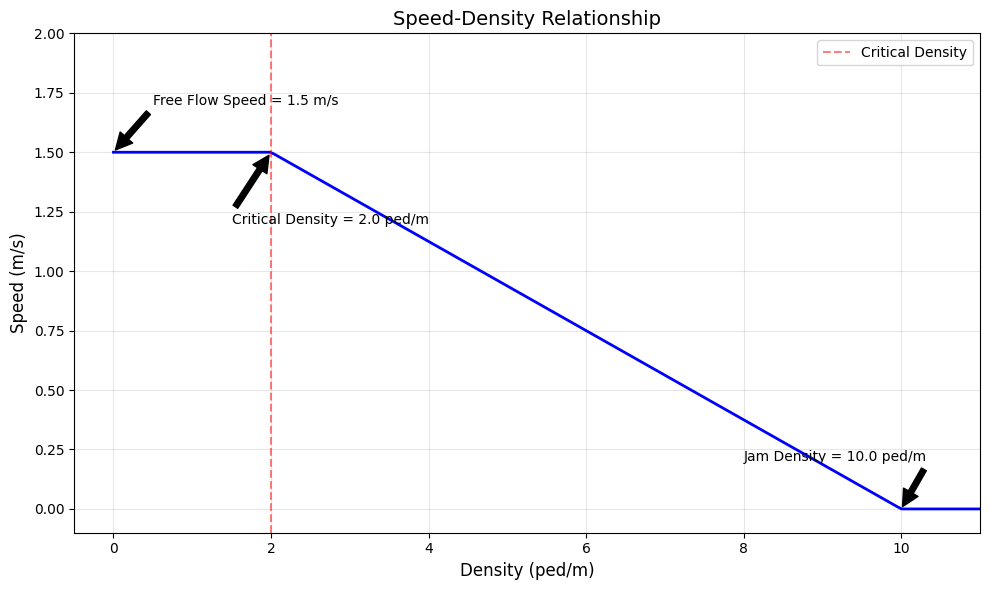

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def cal_travel_speed(density, v_f, k_critical, k_jam):
    """Calculate the travel speed of a link based on density"""
    if density <= k_critical:
        return v_f
    elif k_critical < density:
        return max(0, -v_f * (density - k_jam) / (k_jam - k_critical))

# Set parameters
v_f = 1.5        # free flow speed
k_critical = 2.0 # critical density
k_jam = 10.0     # jam density

# Create density range
densities = np.linspace(0, k_jam + 1, 200)

# Calculate speeds
speeds = [cal_travel_speed(k, v_f, k_critical, k_jam) for k in densities]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(densities, speeds, 'b-', linewidth=2)

# Add vertical line at k_critical
plt.axvline(x=k_critical, color='r', linestyle='--', alpha=0.5, label='Critical Density')

# Add labels and title
plt.xlabel('Density (ped/m)', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.title('Speed-Density Relationship', fontsize=14)

# Add grid
plt.grid(True, alpha=0.3)

# Add legend
plt.legend()

# Add text annotations for key points
plt.annotate(f'Free Flow Speed = {v_f} m/s', 
            xy=(0, v_f), 
            xytext=(0.5, v_f + 0.2),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate(f'Critical Density = {k_critical} ped/m', 
            xy=(k_critical, v_f), 
            xytext=(k_critical - 0.5, v_f - 0.3),
            arrowprops=dict(facecolor='black', shrink=0.05))

plt.annotate(f'Jam Density = {k_jam} ped/m', 
            xy=(k_jam, 0), 
            xytext=(k_jam - 2, 0.2),
            arrowprops=dict(facecolor='black', shrink=0.05))

# Set axis limits
plt.xlim(-0.5, k_jam + 1)
plt.ylim(-0.1, v_f + 0.5)

plt.tight_layout()
plt.show()

In [12]:
import json
import os
with open("./outputs/forky_queues/link_data.json", 'r') as f:
    link_data = json.load(f)

link_data.keys()

dict_keys(['0-1', '1-0', '1-2', '2-1', '1-4', '4-1', '2-3', '3-2'])

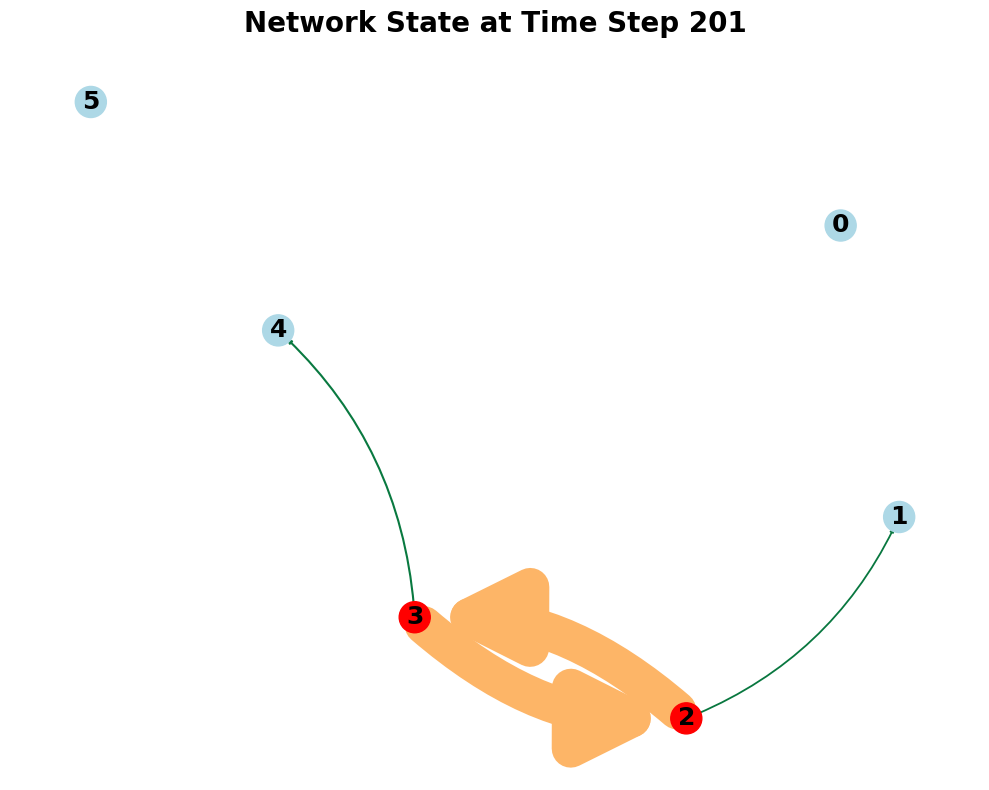

In [44]:
import os
from src.utils.visualizer import NetworkVisualizer
output_dir = os.path.join(".", "outputs")
visualizer = NetworkVisualizer(simulation_dir=os.path.join(output_dir, "long_corridor"))
# visualizer = NetworkVisualizer(simulation_dir=os.path.join(output_dir, "delft_directions"), pos=pos)
time_step = 201
fig, ax = visualizer.visualize_network_state(time_step=time_step, edge_property='density', with_colorbar=False)

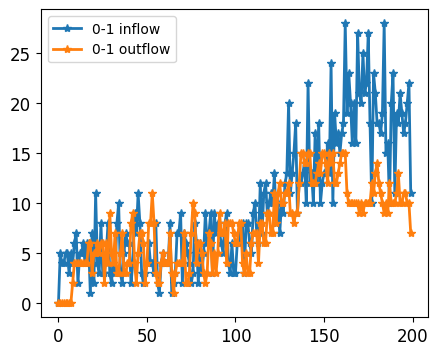

In [10]:
plt.figure(figsize=(5,4))
# plt.plot(link_data["2-3"]["inflow"], label=f'2-3 sending flow',linewidth=2)
plt.plot(link_data["0-1"]["inflow"][0:200],'-*', label=f'0-1 inflow',linewidth=2)
plt.plot(link_data["0-1"]["outflow"][0:200],'-*', label=f'0-1 outflow',linewidth=2)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend()
plt.show()

In [61]:
np.cumsum(np.array(link_data["2-3"]["inflow"]))[-1],np.cumsum(np.array(link_data["2-3"]["outflow"]))[-1]

(10647.0, 10490.0)

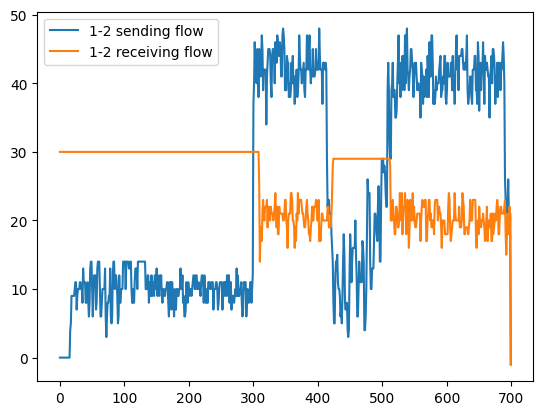

In [62]:
from matplotlib import pyplot as plt
path = ["4-5", "3-5"]

plt.plot(link_data["1-2"]["sending_flow"], label=f'1-2 sending flow')
plt.plot(link_data["2-3"]["receiving_flow"], label=f'1-2 receiving flow')
# plt.plot(np.array(link_data["0-1"]["inflow"])+np.array(link_data["1-0"]["inflow"]), label=f'sum')
#plot horizontal line at 6
# plt.axhline(y=6, color='black', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

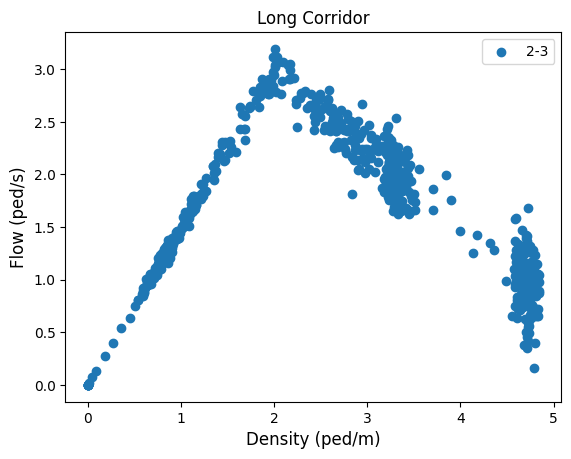

In [63]:
# plot the relation between density and speed using scatter plot
plt.scatter(np.array(link_data["1-2"]["density"])+np.array(link_data["2-1"]["density"]), np.array(link_data["1-2"]["link_flow"])+np.array(link_data["2-1"]["link_flow"]), label=f'2-3')
plt.xlabel('Density (ped/m)', fontsize=12)
plt.ylabel('Flow (ped/s)', fontsize=12)
plt.title("Long Corridor")
plt.legend()
plt.show()

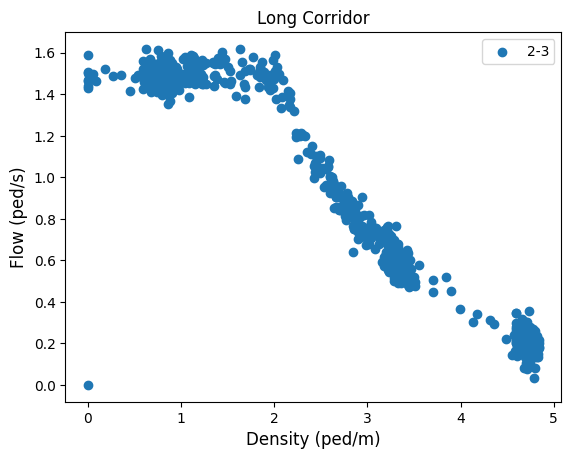

In [65]:
plt.scatter(np.array(link_data["1-2"]["density"])+np.array(link_data["2-1"]["density"]), np.array(link_data["1-2"]["speed"]), label=f'2-3')
plt.xlabel('Density (ped/m)', fontsize=12)
plt.ylabel('Flow (ped/s)', fontsize=12)
plt.title("Long Corridor")
plt.legend()
plt.show()

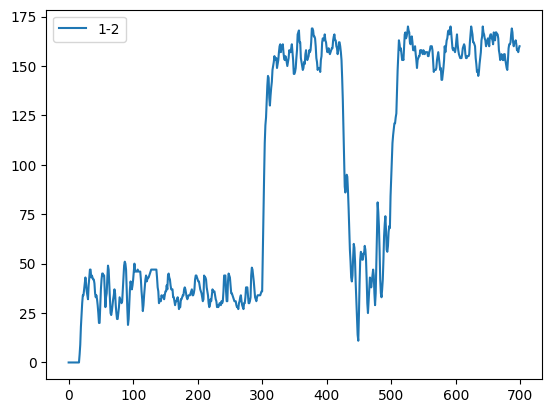

In [136]:
# plt.plot(link_data["1-2"]["num_pedestrians"], label=f'1-2')
plt.plot(link_data["2-3"]["num_pedestrians"], label=f'1-2')
#plot horizontal line at 6
# plt.axhline(y=6, color='black', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [112]:
import json
with open("./outputs/long_corridor/link_data.json", 'r') as f:
    link_data = json.load(f)
# with open("./outputs/spike/link_data.json", 'r') as f:
#     link_data = json.load(f)

In [113]:
np.cumsum(np.array(link_data["2-3"]["inflow"]))[-1],np.cumsum(np.array(link_data["3-4"]["outflow"]))[-1]

(5099.0, 5021.0)

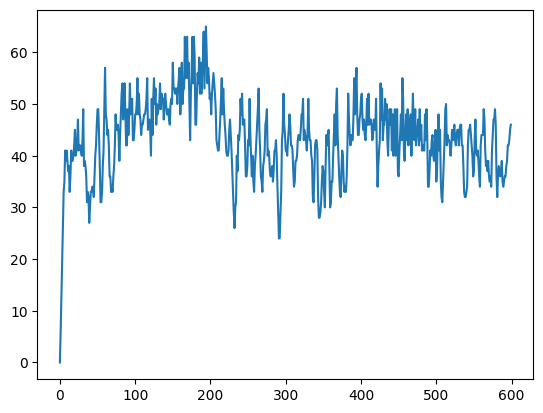

In [114]:
plt.plot(link_data["2-3"]["num_pedestrians"], label=f'2-3')

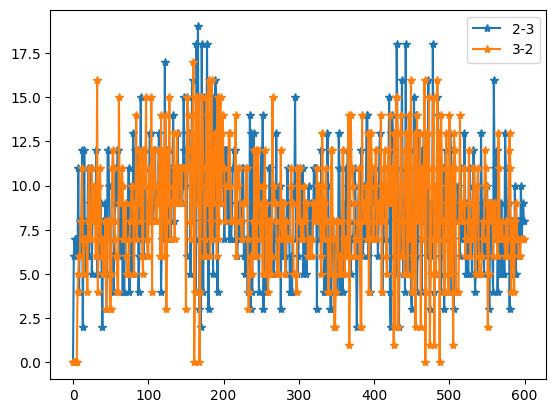

In [115]:
# plt.plot(link_data["2-3"]["sending_flow"], label=f'2-3')
# plt.plot(link_data["2-3"]["receiving_flow"], label=f'3-4')
plt.plot(link_data["2-3"]["inflow"], '-*', label=f'2-3')
plt.plot(link_data["2-3"]["outflow"], '-*', label=f'3-2')
# plt.plot(link_data["3-4"]["inflow"][800:1000], label=f'2-3')
# plt.plot(link_data["3-4"]["outflow"][811:1000], '-*', label=f'3-4')

# plt.plot(np.array(link_data["0-1"]["inflow"])+np.array(link_data["1-0"]["inflow"]), label=f'sum')
#plot horizontal line at 6
# plt.axhline(y=6, color='black', linestyle='--', alpha=0.5)
plt.legend()
plt.show()

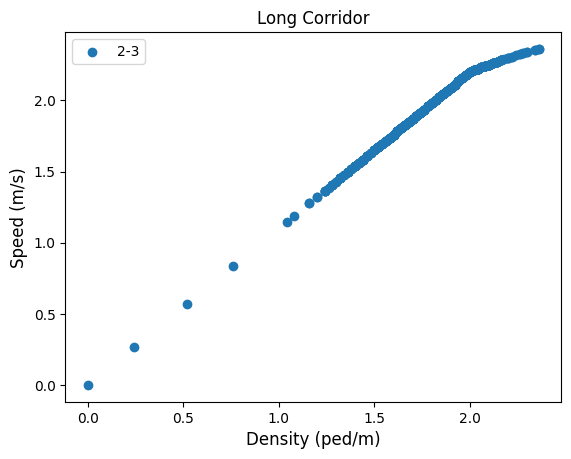

In [87]:
# relation between density and sending flow using scatter plot
# plt.scatter(np.array(link_data["3-4"]["density"])+np.array(link_data["4-3"]["density"]), link_data["3-4"]["sending_flow"], label=f'2-3')

# relation between density and speed
plt.scatter(np.array(link_data["3-2"]["density"])+np.array(link_data["2-3"]["density"]), np.array(link_data["3-2"]["link_flow"])+np.array(link_data["2-3"]["link_flow"]), label="2-3")
# plt.scatter(np.array(link_data["3-4"]["density"])+np.array(link_data["4-3"]["density"]), np.array(link_data["4-3"]["link_flow"])+np.array(link_data["3-4"]["link_flow"]), label="3-4")
# plt.scatter(np.array(link_data["3-2"]["density"])+np.array(link_data["2-3"]["density"]), np.array(link_data["3-2"]["link_flow"])+np.array(link_data["2-3"]["link_flow"]), label="3-2")
# density for separate links
# plt.scatter(np.array(link_data["3-2"]["density"]), np.array(link_data["3-2"]["link_flow"]), label="3-2")
# plt.scatter(np.array(link_data["2-3"]["density"]), np.array(link_data["2-3"]["link_flow"]), label="2-3")
plt.xlabel('Density (ped/m)', fontsize=12)
plt.ylabel('Speed (m/s)', fontsize=12)
plt.title("Long Corridor")
plt.legend()
plt.show()



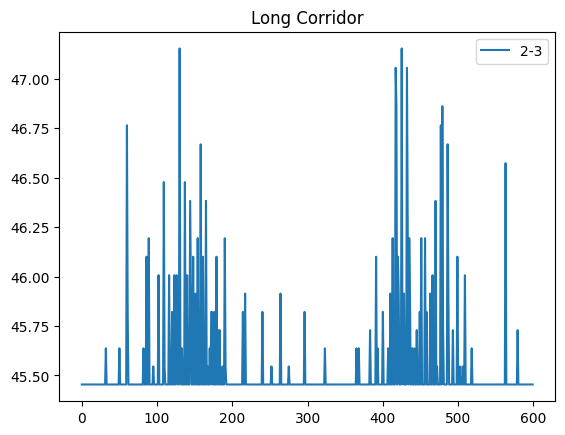

In [232]:
# a = np.where(np.array(link_data["3-4"]["travel_time"])==np.inf, 9000, np.array(link_data["3-4"]["travel_time"]))
# plt.plot(a, label=f'3-4')
plt.plot(np.array(link_data["2-3"]["travel_time"]), label=f'2-3')
plt.title("Long Corridor")
plt.legend()
plt.show()

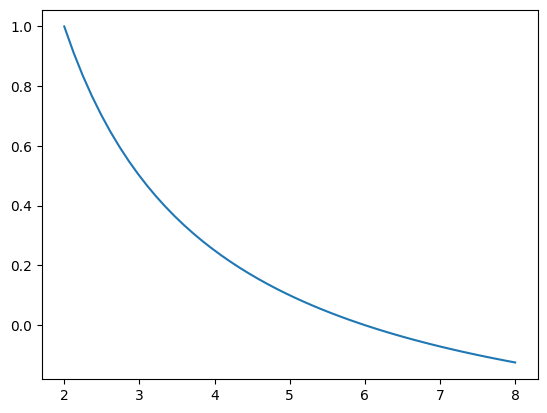

In [553]:
k_c = 2
v_f = 1.1
k_j = 6
theta = 1.13
gamma = 0.545
k = np.linspace(k_c, 8)
# v = (k_c*v_f)/(k_j-k_c)*(k_j/k - 1)
v = 1.5*k_c * (1 / k - 1 / k_j)
# k = np.linspace(0, 5.9)
# v = v_f * np.exp(-(k / theta)**gamma)
plt.plot(k, v)

In [116]:
with open("./outputs/delft_exp/link_data.json", 'r') as f:
    link_data = json.load(f)


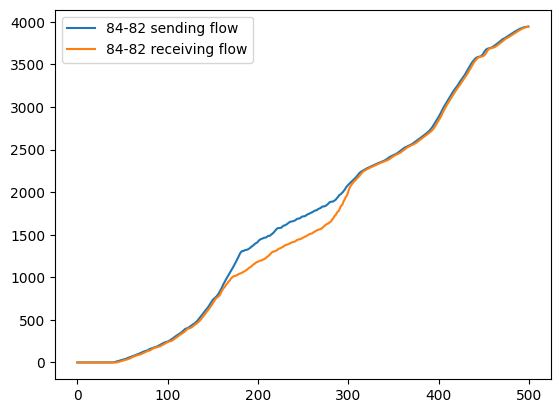

In [117]:
plt.plot(np.cumsum(link_data["84-82"]["inflow"]), label=f'84-82 sending flow')
plt.plot(np.cumsum(link_data["84-82"]["outflow"]), label=f'84-82 receiving flow')

plt.legend()
plt.show()

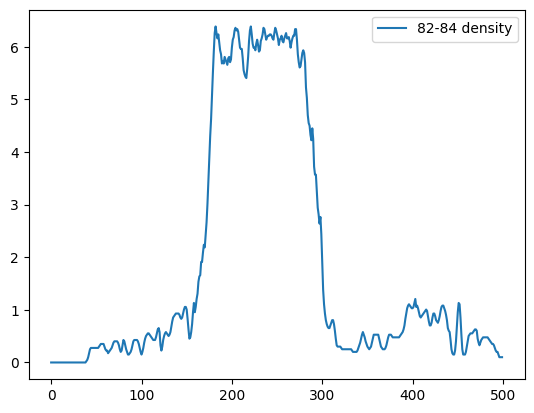

In [118]:
# plt.plot(link_data["82-84"]["inflow"], label=f'82-84 inflow')
plt.plot(link_data["84-82"]["density"], label=f'82-84 density')

plt.legend()
plt.show()

/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_14043/2370230106.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


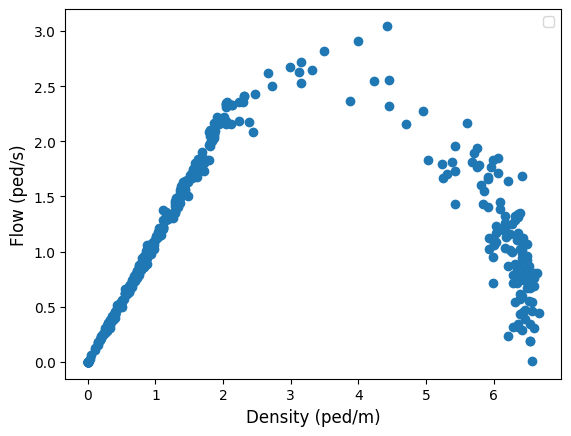

In [119]:
plt.scatter(np.array(link_data["84-82"]["density"])+np.array(link_data["82-84"]["density"]), np.array(link_data["84-82"]["link_flow"])+np.array(link_data["82-84"]["link_flow"]))
# plt.scatter(np.array(link_data["84-82"]["density"])+np.array(link_data["82-84"]["density"]), np.array(link_data["84-82"]["link_flow"]))

plt.xlabel('Density (ped/m)', fontsize=12)
plt.ylabel('Flow (ped/s)', fontsize=12)
plt.legend()
plt.show()

/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_14043/671112809.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


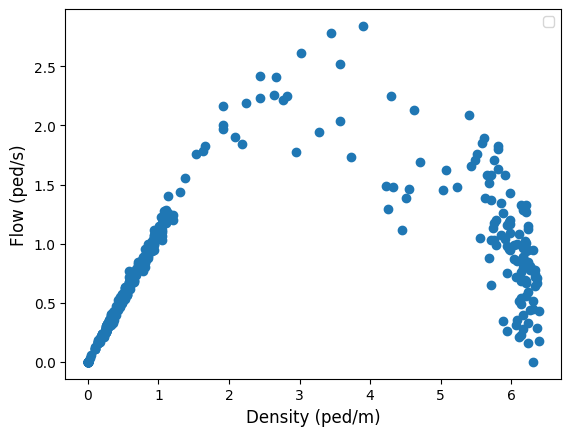

In [120]:
plt.scatter(np.array(link_data["84-82"]["density"]), np.array(link_data["84-82"]["link_flow"]))
# plt.scatter(np.array(link_data["102-162"]["density"]), np.array(link_data["102-162"]["link_flow"]))
plt.xlabel('Density (ped/m)', fontsize=12)
plt.ylabel('Flow (ped/s)', fontsize=12)
plt.legend()
plt.show()

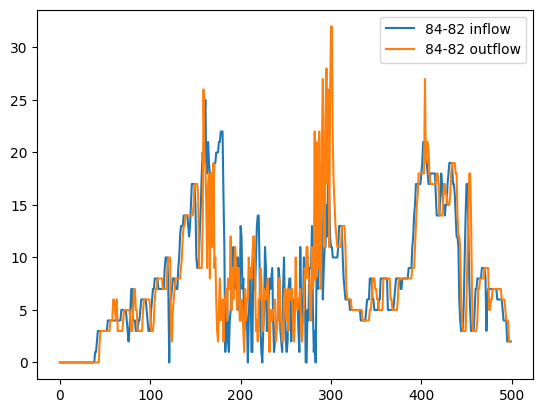

In [123]:
# travel time of link 84-82
# plt.plot(link_data["84-82"]["travel_time"], label=f'84-82 travel time')
plt.plot(link_data["84-82"]["inflow"], label=f'84-82 inflow')
plt.plot(link_data["84-82"]["outflow"], label=f'84-82 outflow')
plt.legend()
plt.show()

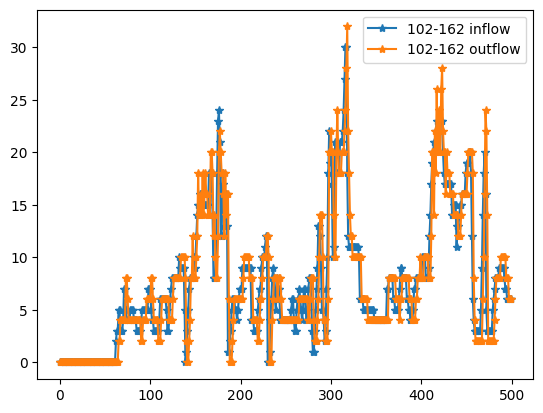

In [125]:
plt.plot(link_data["162-102"]["inflow"], '-*', label=f'102-162 inflow')
plt.plot(link_data["162-102"]["outflow"], '-*', label=f'102-162 outflow')
plt.legend()
plt.show()